In [68]:
import gym
import gym_battleship_basic
import numpy as np
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
import os
import pickle
# from tensorflow.keras import backend
from IPython.display import SVG
import gym
import random
import os
import numpy as np
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.models import load_model
%matplotlib inline
from IPython.display import HTML
import numpy as np
import gym
from matplotlib import colors
import time
import copy
# 1.1 Import tensorflow and other libraries.
import tensorflow as tf
import numpy as np
%matplotlib inline
import pylab
import time
import gc
import os

In [101]:
# os.path.join(os.getcwd(),".\..")
root_path = os.getcwd() # please specific the root path to load pacakages.
output_path = r'.\asset\data'
if os.getcwd().split("\\")[-1] == 'notebooks':
    root_path = os.path.dirname(os.getcwd())
    os.chdir(root_path)
    print(root_path)
# else:

import sys
if root_path not in sys.path:
    sys.path.append(root_path)
from agents.random_Agent import RandomAgent
from agents.CNN_Agent import CNN_Agent
from agents.DoubleModel_DQN import DoubleModel_DQN
from agents.HuntTarget_Agent import HuntTargetAgent
from agents.SingleModel_DQN import DQN_Agent, BattleShipAgent
import imp
import agents.util
imp.reload(agents.util)
from agents.MC_Agent import MCAgent
from agents.MCTS_Agent import MCTS_Battleship
from agents.util import train_data_process, agent_test, single_frame_viz
from agents.util import game_viz


In [74]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Game Intro & Environment Setup

The battleship is a very classic board game with very intuitive rules. This is a 2 players game. For each player, s/he have a 10*10 board to place the fleet and then claim shots on the other players boards. The goal is simply to sink all your opponent's ship.


For example, with the classic rules, there are five ships on board as follows:

![Battleship Board](images\board.png)

Typically, these five ships above are:
* Aircraft Carrier (Size 5)
* Battleship (Size 4)
* Submarine (Size 3)
* Cruiser (Size 3)
* Destroyer	 (Size 2)


Thoughthis is a two players game, Clearly, we could convert this problem to finish the game with smallest number of shot. As long as you could finish the game fast, you will have higher chance to win the game. 

In [2]:
env = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False)
obs = env.step(20)
obs = env.step(45)
obs = env.step(47)

Regarding my program, I set up my game with Open AI API. My environment will take shot as the input of each step and return observations in 2D or 3D.

__Sample Observation 2D__

In this type of observation return, 0 means unexplored cells, 1 means miss and 2 means hit. In the sample result below, we have placed 3 shots and 1 of 3 hit the target.


In [57]:
obs = env.step(34)
print(obs[0])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]
 [1. 2. 2. 2. 2. 2. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


__Sample Observation 3D__

In this type of observation return, there are 3 matrcies that represents explored, misses and hits. 

In [7]:
env = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False, obs_3d=True)
obs = env.step(20)
obs = env.step(45)
obs = env.step(47)

__Explored or Not Matrix__: In this observation, we have placed 3 shots already.

In [8]:
print(obs[0][...,0])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


__Miss or Not Matrix__: In this observation, 2 of our shots misses the target

In [9]:
print(obs[0][...,1])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


__Hit or Not Matrix__: In this observation, 1 of our shots hits the target

In [10]:
print(obs[0][...,2])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Random Agent

This type of agent will keep placing random shots till game ends. This agent takes ~96 steps to finish a game on average

In [9]:
result_save = False
env = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False)
RandomAgent1 = RandomAgent(verbose=False, log_saving=True)
RandomAgent_GameRecord, RandomAgent_game_log =\
    agent_test(agent=RandomAgent1, 
               env=env, 
               game_rounds=50, 
               agent_name='RandomAgent', 
               model_agent=False, 
               log_save=False)

print('average steps uses is {}'.format(RandomAgent_GameRecord['steps'].mean()))
if result_save:
    RandomAgent_GameRecord.to_csv(os.path.join(output_path, 'RandomAgentResult.csv'))
    with open(os.path.join(output_path, 'RandomAgentGamelog.pickle'),'wb') as f:
        pickle.dump(RandomAgent_game_log ,f)
# 

  0%|                                                                                                                                                                                                                   | 0/50 [00:00<?, ?it/s]C:\Users\Muxi\PycharmProjects\Battleship\agents\random_Agent.py:12: RuntimeWarning: invalid value encountered in true_divide
  i, j = np.nonzero(np.nan_to_num(obs / obs) - 1)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 106.92it/s]

average steps uses is 96.08


In [63]:
random_agent_game = game_viz(board_shape=(10,10),agent_name='RandomAgent', 
                           game_hist=RandomAgent_game_log[1],
                           anim_flag=True,
                           obs_3d=False,
                            label_c='white')

![SegmentLocal](images\RandomAgent_Game.gif "segment")

## Hunt & Target Agent

This type of agent will do following:

* Place random shot as search
* Once hit, the explore all nearby cells. If exhuast all nearby cells, back to step 1.

This type of agent takes aroudn 66 steps on average to finish a game.


In [12]:
result_save = False
env = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False, obs_3d=True)
HuntTargetAgent1 = HuntTargetAgent(board_shape=(10,10), verbose=False, log_saving=True)
HuntTargetAgent_GameRecord,SearchHunt_GameDict =\
    agent_test(agent=HuntTargetAgent1, 
               env=env, 
               game_rounds=10, 
               agent_name='SearchHuntAgent', 
               model_agent=False, 
               log_save=True)
print(SearchHunt_GameDict[0]['observations'].shape)
if result_save:
    RandomAgent_GameRecord.to_csv(os.path.join(output_path, 'HuntTargetAgentResult.csv'))
    with open(os.path.join(output_path, 'huntSearch_agentGames.pickle'),'wb') as f:
        pickle.dump(RandomAgent_game_log ,f)
print('average steps uses is {}'.format(HuntTargetAgent_GameRecord['steps'].mean()))

  0%|                                                                                                                                                                                                                   | 0/10 [00:00<?, ?it/s]C:\Users\Muxi\PycharmProjects\Battleship\agents\HuntTarget_Agent.py:48: RuntimeWarning: invalid value encountered in true_divide
  i, j = np.nonzero(np.nan_to_num(obs / obs) - 1)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 186.82it/s]

(68, 10, 10, 3)
average steps uses is 58.8


In [88]:
SearchHunt_game = game_viz(board_shape=(10,10),agent_name='hunt_target_agent', 
                           game_hist=SearchHunt_GameDict[1],
                           anim_flag=True,                           
                           obs_3d=True,
                            label_c='white' )

![SegmentLocal](images\hunt_target_agent_Game2.gif "segment")

## CNN Agent

Another methodology to estimate the probability that there is a ship in a specific cell. Following picture shows the main ideas of this methodology.

![Probability Density Function](images\probDensityFunc.png)

There are many ways to calculate the probability. What I implented is to use a CNN model to predict this.


__Input__: the 3D observation from the environment

__target__:


| 0|1 |2|3|4|5|6|
| --- | --- | --- | --- | --- | --- | --- |
| 1 | 0 | 0 | 0 | 0 |0 | 0 |
| 1 | 0 | 2 | 0 | 0 |3 | 0 |
| 1 | 0 | 2 | 0 | 0 |3 | 0 |
| 1 | 0 | 2 | 0 | 0 |3 | 0 |
| 1 | 0 | 2 | 0 | 0 |0 | 0 |

In addition, we don't need to know whether the ship is a n aircraft carrier or a battle ship. So I further convert this table to 0-1.  Then we have a typical classification problem.

In [16]:
env = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False, obs_3d=True)
trained_model = load_model(r'.\agents\model\CNN_AgentModel.model')
CNN_Agent1 = CNN_Agent(env=env, trained_model=trained_model, log_saving=False)
CNN_GameRecord,CNN_GameDict =\
    agent_test(agent=CNN_Agent1, 
               env=env, 
               game_rounds=10, 
               agent_name='DQN_SModel', 
               model_agent=True, 
               log_save=True)
if result_save:
    CNN_GameRecord.to_csv(os.path.join(output_path, 'CNN_AgentResult.csv'))
    with open(os.path.join(output_path, 'CNN_AgentGames.pickle'),'wb') as f:
        pickle.dump(CNN_GameDict ,f)
print('average steps uses is {}'.format(CNN_GameRecord['steps'].mean()))
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 16.69it/s]

average steps uses is 51.5


In [ ]:
CNN_Model_game = game_viz(board_shape=(10,10),
                          agent_name='CNN_Model_Agent', 
                          game_hist=CNN_GameDict[2],
                          anim_flag=True, 
                          model_agent=True,
                          obs_3d=True,
                          value_range=(-1,1))

![SegmentLocal](images\CNN_Model_Agent_Game.gif "segment")

## DQN Agent

This is the typical DQN agent, which formula the strategy based on Q table. I have tried 3 types of implementation. 

* __Keras RL__: this is the off the shelf model. However, it doesn't perform well. After over thousands steps of training, it failed to converge.
* __Single & Double Model DQN__: I then build customized agent. The main change I have done are:
    * __MASK ILLEGAL MOVEMENT__: one problem I notice from Keras RL is that the agent keep placing shots on the same cells again and again. To speed up the training, I have removed those explored cells from DQN's action space. Currently, my agent will only place these duplicated shots during exploration phase.
    * __MODEL PRE-TRAIN__: Instead of training the model from scratch, I first train the model with the game logs from the hunt  & target agent. For my models, I have used 1,000 games from the hunt and target agents. Result shows this step significantly improves my agent's performance. 

### Keras RL

In [13]:
dqn_env = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False,obs_3d=True)
nb_actions = dqn_env.action_space.n
frame = Input(shape=(1, 10, 10,3))
x = Flatten()(frame)
x = Dense(32, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(nb_actions, activation='linear')(x)
model2 = Model(inputs=frame, outputs=output)
print(model2.summary())
# return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 10, 10, 3)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                9632      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               3300      
Total params: 15,044
Trainable params: 15,044
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
policy = EpsGreedyQPolicy()
# policy = GreedyQPolicy()
memory = SequentialMemory(limit=50000, window_length=1)
dqn = DQNAgent(model=model2, nb_actions=nb_actions, memory=memory, 
               nb_steps_warmup=400,
               gamma=.99, target_model_update=1e-3, 
               policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(dqn_env, nb_steps=50000, visualize=False, verbose=2)

Training for 50000 steps ...
   983/50000: episode: 1, duration: 5.035s, episode steps: 983, steps per second: 195, episode reward: -892999920.000, mean reward: -908443.459 [-1000000.000, 9.000], mean action: 56.641 [0.000, 99.000], mean observation: 0.328 [0.000, 1.000], loss: 428911453145.292114, mean_absolute_error: 22256.516996, mean_q: -537.728797
  3843/50000: episode: 2, duration: 16.801s, episode steps: 2860, steps per second: 170, episode reward: -2764999925.000, mean reward: -966783.191 [-1000000.000, 9.000], mean action: 54.203 [0.000, 99.000], mean observation: 0.475 [0.000, 1.000], loss: 67856904192.000000, mean_absolute_error: 1162925.375000, mean_q: -894480.625000
  5531/50000: episode: 3, duration: 10.209s, episode steps: 1688, steps per second: 165, episode reward: -1596999921.000, mean reward: -946090.001 [-1000000.000, 9.000], mean action: 52.824 [0.000, 98.000], mean observation: 0.383 [0.000, 1.000], loss: 45791084544.000000, mean_absolute_error: 2517975.750000, me

__Notes__: apparently, the agloirhtm failed to converge

### Single Model 

In [93]:
#### 
result_save = False
#####
trained_DQN_model = load_model(r'.\agents\model\DQN_V2_06102020_1.model')
dqn_env = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False, obs_3d=True)
DQN_SingleMdel = BattleShipAgent(model=trained_DQN_model, log_saving=True)
DQN_SingleModel_GameRecord,DQN_SingleMdel_GameDict =\
    agent_test(agent=DQN_SingleMdel, 
               env=env, 
               game_rounds=10, 
               agent_name='DQN_SModel', 
               model_agent=True, 
               log_save=True)


if result_save:
    CNN_GameRecord.to_csv(os.path.join(output_path, 'DQN_SingleMdelResult.csv'))
    with open(os.path.join(output_path, 'DQN_SingleMdelGames.pickle'),'wb') as f:
        pickle.dump(CNN_GameDict ,f)
print('average steps uses is {}'.format(DQN_SingleModel_GameRecord['steps'].mean()))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.85it/s]

average steps uses is 77.8


In [ ]:
DQN_SModel_game = game_viz(board_shape=(10,10),agent_name='DQN_SingleModel_Agent', 
                           game_hist=DQN_SingleMdel_GameDict[2],
                           anim_flag=True, 
                           model_agent=True,
                           obs_3d=True,
                           value_range=(-20,+20))

![SegmentLocal](images\DQN_SingleModel_Agent_Game.gif "segment")

### Double Model

In [21]:
dqn_env = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False, obs_3d=True)
# DQN_V3_06092020_2
trained_DQN_model = load_model(r'.\agents\model\DQN_V3_06102020_1.model')
dqn_DModel_agent_V1 = DoubleModel_DQN(env=dqn_env, model=trained_DQN_model, log_saving=False)
DQN_DoubleModel_GameRecord,_ =\
    agent_test(agent=dqn_DModel_agent_V1, 
               env=env, 
               game_rounds=10, 
               agent_name='RandomAgent', 
               model_agent=True, 
               log_save=False)
if result_save:
    CNN_GameRecord.to_csv(os.path.join(output_path, 'DQN_DoubleModelResult.csv'))
    with open(os.path.join(output_path, 'DQN_DoubleModelGames.pickle'),'wb') as f:
        pickle.dump(CNN_GameDict ,f)
print('average steps uses is {}'.format(DQN_DoubleModel_GameRecord['steps'].mean()))
    


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81it/s]

average steps uses is 54.7


In [92]:
DQN_DModel_game = game_viz(board_shape=(10,10),agent_name='DQN_DoubleModel_Agent', 
                           game_hist=DQN_DoubleModel_GameDict[1],
                           anim_flag=True, 
                           model_agent=True,
                           obs_3d=True ,
                          value_range=(-20,+20))

![SegmentLocal](images\DQN_DoubleModel_Agent_Game.gif "segment")

## MC Agent

Without Multiprocessing, the MC_Agent takes ~1 mins to finish a game. With multiprocessing, each game only takes ~10 seconds. However, this is still much slower compared with other agents.

In [34]:
result_save = False
env_mc = gym.make('battleshipBasic-v0',board_shape=(10,10), verbose=False, obs_3d=False)
MC_Agent1 = MCAgent(board_shape=(10,10),
                    multiprocess=False,  
                    verbose=False, 
                    log_saving=True, 
                    simulation_round=500)

MCAgent_GameRecord,MCAgent_GameDict =\
    agent_test(agent=MC_Agent1, 
               env=env_mc,                
               game_rounds=2, 
               agent_name='MCAgent', 
               model_agent=True, 
               log_save=True)

if result_save:
    CNN_GameRecord.to_csv(os.path.join(output_path, 'MCAgent_Result.csv'))
    with open(os.path.join(output_path, 'MCAgent_DoubleModelGames.pickle'),'wb') as f:
        pickle.dump(CNN_GameDict ,f)
print('average steps uses is {}'.format(MCAgent_GameRecord['steps'].mean()))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:04<00:00, 62.26s/it]

average steps uses is 35.5


In [98]:
DQN_DModel_game = game_viz(board_shape=(10,10),agent_name='MC_Agent', 
                           game_hist=MCAgent_GameDict[0],
                           anim_flag=True, 
                           model_agent=True,
                           obs_3d=False,
                           value_range=(-1,1),
                          label_c='White')
HTML(DQN_DModel_game.to_html5_video())

## Result Summary

Following plot shows the result comparison among my agents.

* The CNN model based agent performs the best with average steps around 55.
* The double models DQN performs slightly worse compared with CNN with an average steps of 58.
* The single model DQN didn't beat the hunt & target agent with an average steps of 72

In [102]:
MC_GameRecord = pd.read_csv(os.path.join(output_path, 'MC_Agent_test.csv'))
RandomAgent_GameRecord = pd.read_csv(os.path.join(output_path, 'RandomAgentResult.csv'))
HuntTargetAgent_GameRecord= pd.read_csv(os.path.join(output_path, 'HuntTargetAgentResult.csv'))
DQN_SingleModel_GameRecord= pd.read_csv(os.path.join(output_path, 'DQN_SingleModel.csv'))
DQN_DoubleModel_GameRecord= pd.read_csv(os.path.join(output_path, 'DQN_Double.csv'))
CNN_GameRecord= pd.read_csv(os.path.join(output_path, 'CNN_gameRecord.csv'))

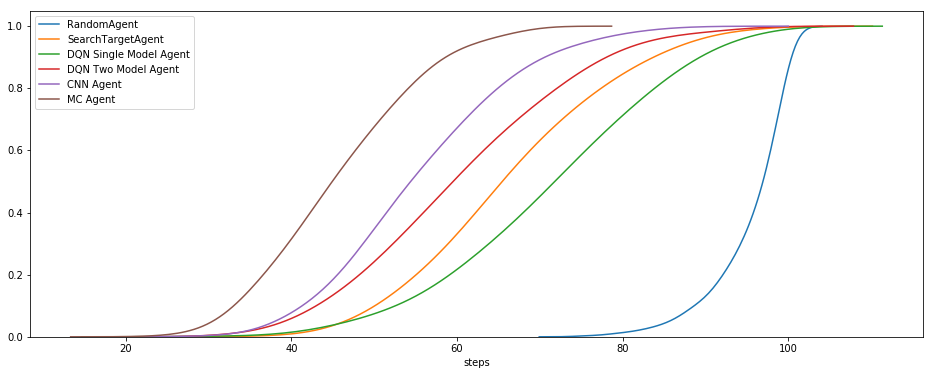

In [104]:
# all_record['steps'].hist(cumulative=True,
# #                          density=1, 
#                          bins=1000,figsize=(12,4))
# plt.show()
import seaborn as sns
fig, ax = plt.subplots(figsize=(16,6))
kwargs = {'cumulative': True}
sns.distplot(RandomAgent_GameRecord['steps'],  kde_kws=kwargs,
             ax=ax, kde=True,hist=False, label='RandomAgent')
sns.distplot(HuntTargetAgent_GameRecord['steps'],ax=ax, kde_kws=kwargs,
             kde=True,hist=False, label='SearchTargetAgent')
sns.distplot(DQN_SingleModel_GameRecord['steps'],ax=ax, kde_kws=kwargs,
             kde=True,hist=False, label='DQN Single Model Agent')
sns.distplot(DQN_DoubleModel_GameRecord['steps'],ax=ax, kde_kws=kwargs,
             kde=True,hist=False, label='DQN Two Model Agent')
sns.distplot(CNN_GameRecord['steps'],ax=ax, kde_kws=kwargs,
             kde=True,hist=False, label='CNN Agent')
sns.distplot(MC_GameRecord['steps'],ax=ax, kde_kws=kwargs,
             kde=True,hist=False, label='MC Agent')
# ax.set_xlim([0, 100])